In [ ]:
# default_exp getting_started

# Building a simple neural network with Pytorch

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.all import *

In [ ]:
# export
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch.nn as nn

## Datasets and Dataloaders

TODO:
- What is a Tensor? talk about torch

In [ ]:
# export
def linear_function_dataset(a, b, n=100, show_plot=False):
    r"""
        Creates a Pytorch's `TensorDataset` with `n` random samples of the 
        linear function y = `a`*x + `b`. `show_plot` dcides whether or not to 
        plot the dataset
    """
    x = torch.randn(n, 1)
    y = a*x + b + 0.1*torch.randn(n, 1)
    if show_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(x, y)
    return TensorDataset(x, y)

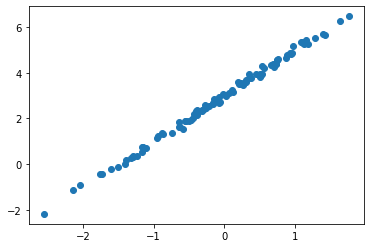

In [ ]:
a = 2
b = 3
n = 100
data = linear_function_dataset(a, b, n, show_plot=True)
test_eq(type(data), TensorDataset)

In every machine/deep learning experiment, we need to have at least two datasets:
 - training: used to train the model
 - validation: used to validate the model after each training step. It allows to detect overfitting and adjust the hyperparameters of the model properly

In [ ]:
train_ds = linear_function_dataset(a, b, n=100)
valid_ds = linear_function_dataset(a, b, n=20)

A dataloader combines a dataset an a sampler that samples data into **batches**, and provides an iterable over the given dataset. 

In [ ]:
bs = 10
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, shuffle=False)

In [ ]:
for i, data in enumerate(train_dl, 1):
    x, y = data
    print(f'batch {i}: x={x.shape} ({x.device}), y={y.shape} ({y.device})')

batch 1: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 2: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 3: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 4: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 5: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 6: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 7: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 8: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 9: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)
batch 10: x=torch.Size([10, 1]) (cpu), y=torch.Size([10, 1]) (cpu)


### Defining a Pytorch model

In [ ]:
#export
class LinRegModel(nn.Module):
    def __init__(self): 
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
    def forward(self, x): 
        return x*self.a + self.b